Failed to set position to database.attempt to write a readonly database


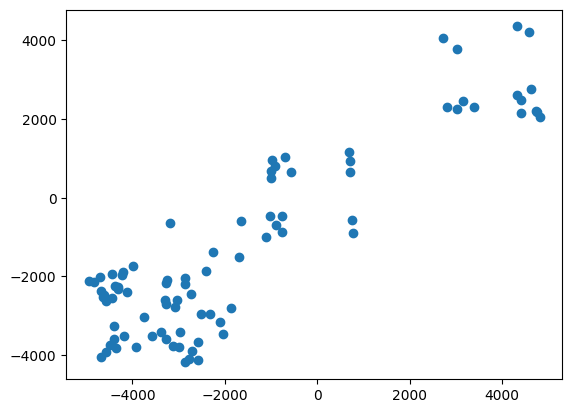

In [10]:
import MF
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

def init_db():
    conn = sqlite3.connect("../../api/db.sqlite3", isolation_level=None)   
    c = conn.cursor()
    # c.execute("pragma table_info(backend_app_music)")
    # print(c.fetchall())
    return c, conn

def get_data(c : sqlite3.Cursor): 
    c.execute("SELECT  music_id, views, title FROM backend_app_music ORDER BY music_id ASC")
    music = pd.DataFrame(c.fetchall(), columns=["music_id", "views", "title"])
    c.execute("SELECT user_id FROM backend_app_appuser ORDER BY user_id ASC")
    user = pd.DataFrame(c.fetchall(), columns=["user_id"])
    c.execute("SELECT user_id_id, music_id_id FROM backend_app_favorite")
    ratings = pd.DataFrame(c.fetchall(), columns=["user_id", "music_id"])
    ratings["rating"] = 1
    return music, user, ratings

def set_position(data: list, c: sqlite3.Cursor) -> None:
    try :
        # floor the position to 2 decimal places
        c.executemany("UPDATE backend_app_music SET position_x=?, position_y=? WHERE music_id=?", data)
    except Exception as e:
        print("Failed to set position to database." + str(e))
    return

def calc_position(rating_matrix: pd.DataFrame, music: pd.DataFrame, max_length: float = 5000, max_views: float = 400000000):
    np.random.seed(seed=32)
    _, H = MF.NonNegativeMatrixFactorization(rating_matrix)
    # centerize the position by median
    H[0] = H[0] - np.average(H[0])
    H[1] = H[1] - np.average(H[1])
    # the more views, the more centerize
    # music["views"] = music["views"] 
    for i in range(len(music)):
        # compare and set views column with max_views
        if music["views"][i] > max_views:
            music.loc[i, "views"] = max_views
    # music["views"] = np.log(music["views"] + 1)
    for i in range(len(music)):
        if H[0][i] == 0 and H[1][i] == 0:
            H[0][i] = np.random.rand()
            H[1][i] = np.random.rand()
        length = np.sqrt(H[0][i]**2 + H[1][i]**2)
        views = music["views"][i]
        H[0][i] = (H[0][i] / length) 
        H[1][i] = (H[1][i] / length) 
        H[0][i] = H[0][i] * (1 - (views / (music["views"].max() + 1000000))) * max_length + (np.random.randint(400,1200) if np.random.rand() > 0.5 else np.random.randint(-1200,-400))
        H[1][i] = H[1][i] * (1 - (views / (music["views"].max() + 1000000))) * max_length + (np.random.randint(400,1200) if np.random.rand() > 0.5 else np.random.randint(-1200,-400))
    # floor the position to 2 decimal places
    data = [(float(round(H[0][i], 2)), float(round(H[1][i], 2)),str(music["music_id"][i])) for i in range(len(music))]
    # for i in range(len(music)):
    #     print(data[i], music["views"][i], music["title"][i])
    plt.scatter(H[0], H[1])
    return data, H
    

if __name__ == "__main__":
        conn = sqlite3.connect("../../api/db.sqlite3", isolation_level=None)   
        c = conn.cursor()
        music, user, ratings = get_data(c)
        rating_matrix = MF.df2sparse(ratings, user, music)
        data, H = calc_position(rating_matrix, music)
        set_position(data,  c)
    
    

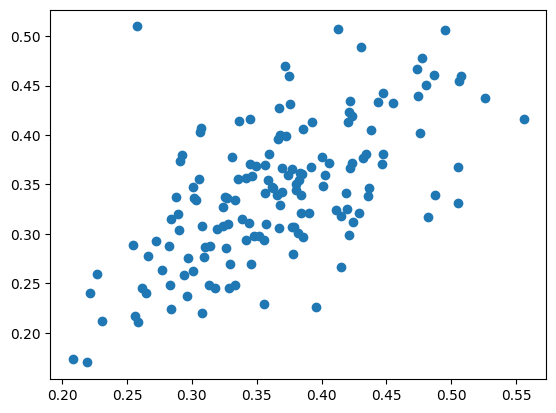

In [ ]:
df_rating = pd.read_csv("../data/rating.csv", header=0)
df_user = pd.read_csv("../data/user.csv", header=0)
df_music = pd.read_csv("../data/music.csv", header=0)
ratings = MF.df2sparse(df_rating, df_user, df_music)
_, H = MF.NonNegativeMatrixFactorization(ratings)
plt.scatter(H[0], H[1])
